# GRAPH - Graph Mining - CS - PARIS - SACLAY (2023-2024)

## Professor: Nacéra Seghouani
### Students: Lucas J. Velôso  and Paul Canal

# Installing packages and importing modules

In [ ]:
%%capture
!pip uninstall -y python-louvain;
!pip install -U python-louvain;

In [ ]:
import os
import gzip
import time

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.community import girvan_newman
import community as community_louvain

# Downloading the Data

The dataset from Stanford's SNAP contains Facebook 'circles' or friends lists, featuring anonymized node profiles, circles, and ego networks collected via a Facebook app. With 4,039 nodes and 88,234 edges, it showcases detailed network dynamics including average clustering coefficients and the number of triangles. The anonymization process obscured feature interpretations, allowing for analysis of connections without revealing specific attributes like political affiliations. It's part of a study on discovering social circles in ego networks, referenced in a 2012 NIPS paper by McAuley and Leskovec.

## Downloading

In [ ]:
# Function to download a file using wget
def download_file(url: str, destination_folder: str) -> None:
    """
    Downloads a file from the specified URL into the destination folder using wget.

    Args:
        url: The URL of the file to download.
        destination_folder: The folder where the file should be saved.

    Returns:
        None
    """
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Construct the command to download the file
    command = f"wget -P {destination_folder} {url}"

    # Execute the download command
    os.system(command)
    print('Download completed successfully!!')

In [ ]:
file_url_facebook = "http://snap.stanford.edu/data/facebook_combined.txt.gz"
file_url_grqc = "https://snap.stanford.edu/data/ca-GrQc.txt.gz"
destination = "/content/"

download_file(file_url_facebook, destination)
download_file(file_url_grqc, destination)

Download completed successfully!!
Download completed successfully!!


## Opening the .zip

In [ ]:
def extract_gz_to_folder(gz_path: str, output_folder: str) -> None:
    """
    Extracts the contents of a .gz file and saves it to a specified folder.

    Args:
        gz_path: The file path of the .gz file to be extracted.
        output_folder: The folder path where the extracted file will be saved.

    Returns:
        None
    """
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define the output file name based on the .gz file
    output_file_path = os.path.join(output_folder, os.path.basename(gz_path).replace('.gz', ''))

    # Open the .gz file and create a new file in the output folder
    with gzip.open(gz_path, 'rb') as gz_file:
        with open(output_file_path, 'wb') as output_file:
            # Copy the decompressed content to the new file
            output_file.write(gz_file.read())

    print('The .gz was read successfully!!')

In [ ]:
extract_gz_to_folder('/content/facebook_combined.txt.gz', '/content/data')
extract_gz_to_folder('/content/ca-GrQc.txt.gz', '/content/data')

The .gz was read successfully!!
The .gz was read successfully!!


# Opening the data

In [ ]:
def create_graph_from_txt(filepath: str) -> nx.Graph:
    """
    Reads a text file with edge list and creates a graph using NetworkX, considering only nodes up to a specified number.

    Args:
        filepath: The path to the text file containing the edge list.
        num_nodes_to_consider: The maximum node number to include in the graph.

    Returns:
        A NetworkX graph object created from the edge list in the text file, considering only the specified nodes.
    """
    # Create a new graph
    G = nx.Graph()

    # Open the text file and read lines
    with open(filepath, 'r') as file:
        for line in file:
            if line[0] == '#':
                continue
            # Split each line into source and target node
            source, target = map(int, line.strip().split())
            # Add edge to the graph
            G.add_edge(source, target)

    return G

In [ ]:
layout_seed = 2024

def plot_graph(G: nx.Graph, title: str, layout_seed: int = layout_seed) -> None:
    """
    Plots a NetworkX graph.

    Args:
        G: A NetworkX graph object.
        title: The title for the plot.
        layout_seed: The seed for the layout generation to ensure consistent positioning.

    Returns:
        None
    """
    plt.figure(figsize=(10, 8))

    # Draw the graph
    pos = nx.spring_layout(G, seed=layout_seed)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=15)

    # Show the plot
    plt.title(title)
    plt.axis('off')
    plt.show()

    return pos # to keep it for later uses

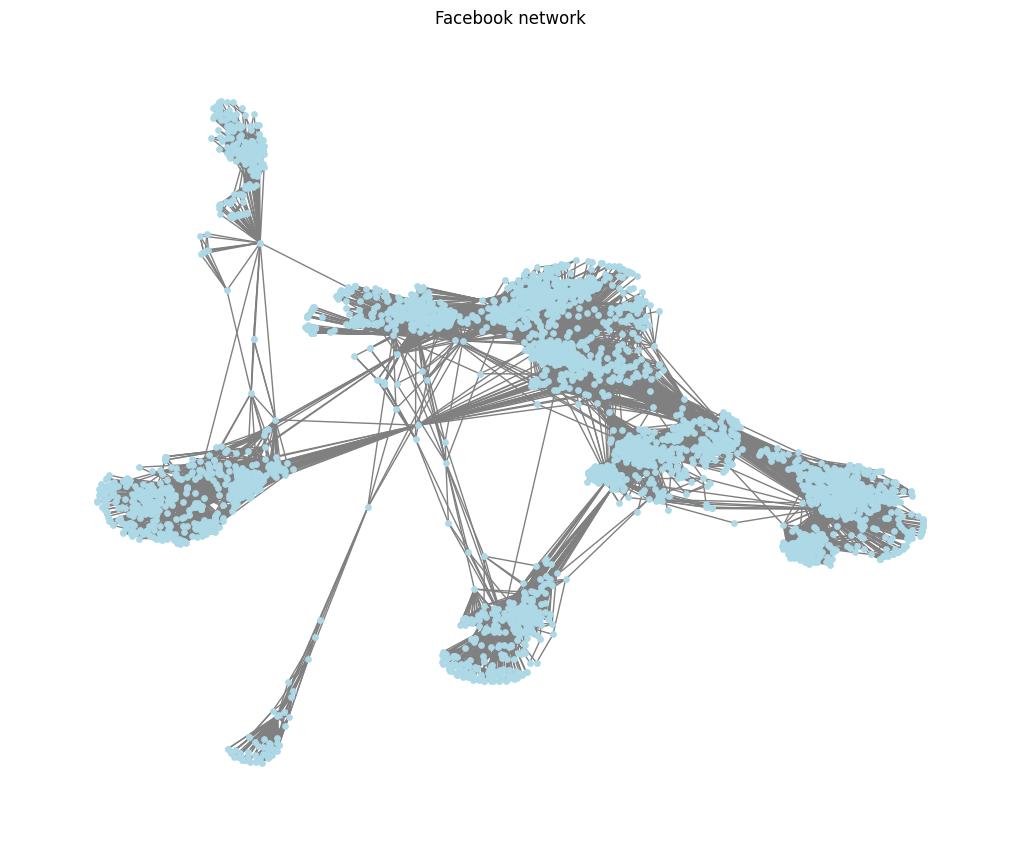

In [ ]:
facebook = create_graph_from_txt('/content/data/facebook_combined.txt')
pos_facebook = plot_graph(facebook, "Facebook network")

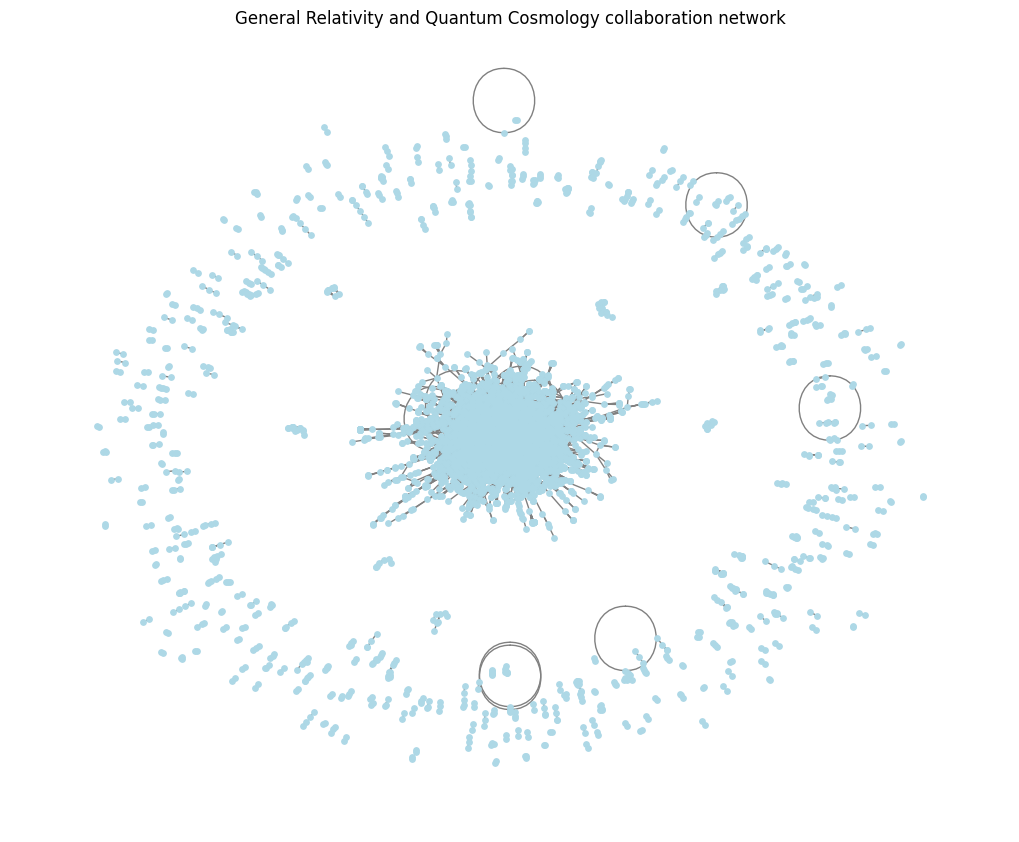

In [ ]:
grqc = create_graph_from_txt('/content/data/ca-GrQc.txt')
pos_grqc = plot_graph(grqc, "General Relativity and Quantum Cosmology collaboration network")

In [ ]:
grqc_cleaned = grqc.copy()

for component in list(nx.connected_components(grqc_cleaned)):
    if len(component) < 5:
        for node in component:
            grqc_cleaned.remove_node(node)

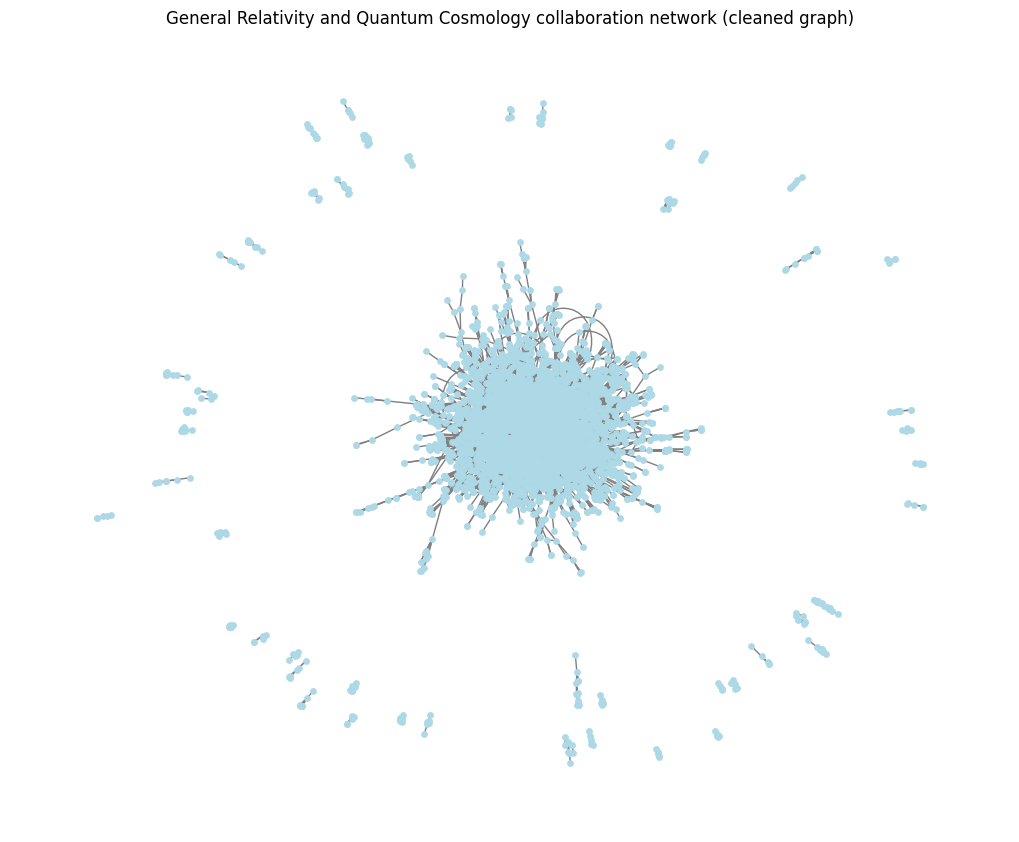

In [ ]:
pos_grqc_cleaned = plot_graph(grqc_cleaned, "General Relativity and Quantum Cosmology collaboration network (cleaned graph)")

# Centrality Analysis



In [ ]:
def sigmoid(x: float) -> float:
    """
    Sigmoid function for normalization.

    Args:
        x: The input value.

    Returns:
        The sigmoid of x.
    """
    return 1 / (1 + np.exp(-x))

In [ ]:
def plot_graph_centrality(G: nx.Graph, centrality: dict, title: str, pos: dict = None, max_node_size: float = 150, min_node_size: float = 1, cmap=plt.cm.viridis, edge_alpha: float = 0.5, node_alpha: float = 0.9, layout_seed: int = layout_seed) -> None:
    """
    Plots the graph with nodes colored according to their centrality values, and sizes adjusted by a sigmoid function.
    Allows for separate transparency settings for nodes and edges.

    Args:
        G: The graph to be plotted.
        centrality: A dictionary with nodes as keys and centrality values as values.
        title: The title for the plot.
        max_node_size: maximum node size.
        min_node_size: minimum node size.
        cmap: The colormap for node colors.
        edge_alpha: The transparency level for edges.
        node_alpha: The transparency level for nodes.
        layout_seed: The seed for the layout generation to ensure consistent positioning.

    Returns:
        None
    """
    # Normalize centrality values to lie between 0 and 1 for coloring
    max_centrality_value = max(centrality.values())
    centrality_normalized = {node: value / max_centrality_value for node, value in centrality.items()}

    # Generate colors for each node based on centrality
    node_colors = [centrality_normalized[node] for node in G.nodes()]

    a = 2*(max_node_size-min_node_size)
    b = max_node_size-a
    node_sizes = [a * sigmoid(c / max_centrality_value) + b for c in centrality.values()]
    # max_node_size + 2*(max_node_size-min_node_size) * (sigmoid(c / max_centrality_value) - 1)

    if pos == None:
        pos = nx.spring_layout(G, seed=layout_seed)  # Positions for all nodes

    # Draw the graph with separate transparency for edges and nodes
    plt.figure(figsize=(10, 8))
    # Draw edges with specified edge transparency
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha, edge_color='gray')
    # Draw nodes with specified node transparency
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=cmap, alpha=node_alpha)

    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Centrality')
    plt.axis('off')  # Turn off the axis
    plt.show()

In [ ]:
def centrality_analysis(G, pos: dict = None):
    centralities = dict()

    degree_centrality = nx.degree_centrality(G)
    plot_graph_centrality(G, degree_centrality, 'Degree Centrality', pos=pos)
    centralities["degree_centrality"] = degree_centrality

    neighborhood_connectivity = nx.average_neighbor_degree(G)
    plot_graph_centrality(G, neighborhood_connectivity, 'Neighborhood Connectivity', pos=pos, max_node_size=15)
    centralities["neighborhood_connectivity"] = neighborhood_connectivity

    eigenvector_centrality = nx.eigenvector_centrality(G)
    plot_graph_centrality(G, eigenvector_centrality, 'Eigenvector Centrality', pos=pos)
    centralities["eigenvector_centrality"] = eigenvector_centrality

    pagerank_centrality = nx.pagerank(G)
    plot_graph_centrality(G, pagerank_centrality, 'PageRank Centrality', pos=pos)
    centralities["pagerank_centrality"] = pagerank_centrality

    ''' Too long to compute
    katz_centrality = nx.katz_centrality(G)
    plot_graph_centrality(G, katz_centrality, 'Katz Centrality', pos=pos)
    '''

    clustering_coefficient = nx.clustering(G)
    plot_graph_centrality(G, clustering_coefficient, 'Clustering Coefficient', pos=pos, max_node_size=5)
    centralities["clustering_coefficient"] = clustering_coefficient

    closeness_centrality = nx.closeness_centrality(G)
    plot_graph_centrality(G, closeness_centrality, 'Closeness Centrality', pos=pos, max_node_size=15)
    centralities["closeness_centrality"] = closeness_centrality

    betweenness_centrality = nx.betweenness_centrality(G)
    plot_graph_centrality(G, betweenness_centrality, 'Betweenness Centrality')
    centralities["betweenness_centrality"] = betweenness_centrality

    return centralities

<ipython-input-40-551b80c6e83f>:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Centrality')


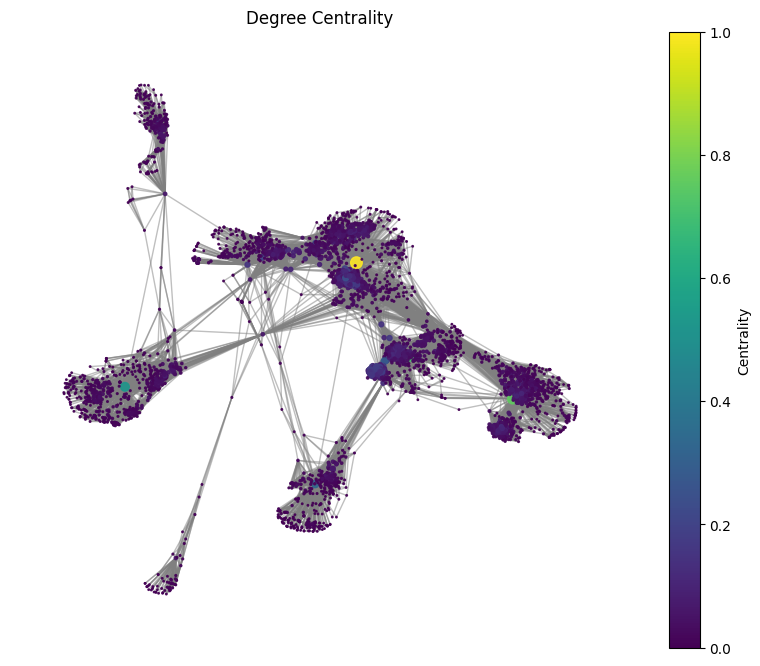

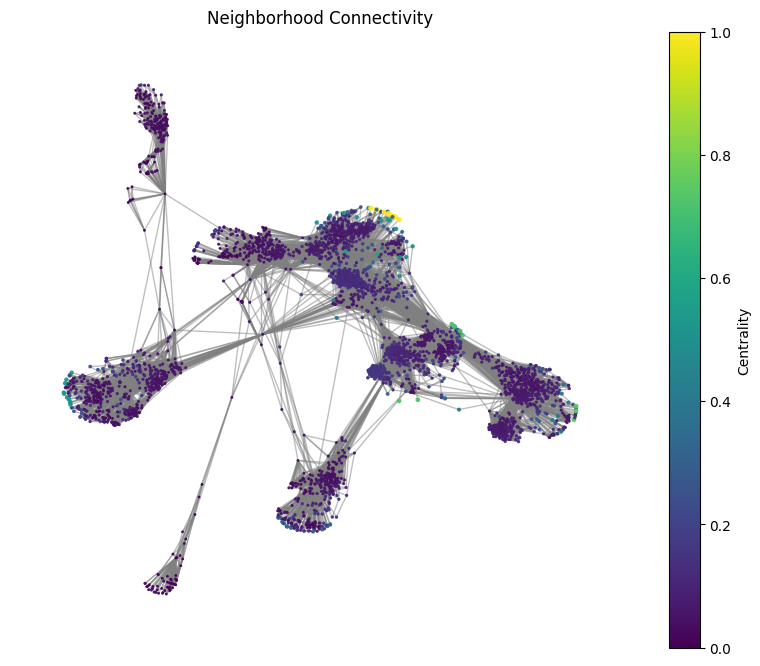

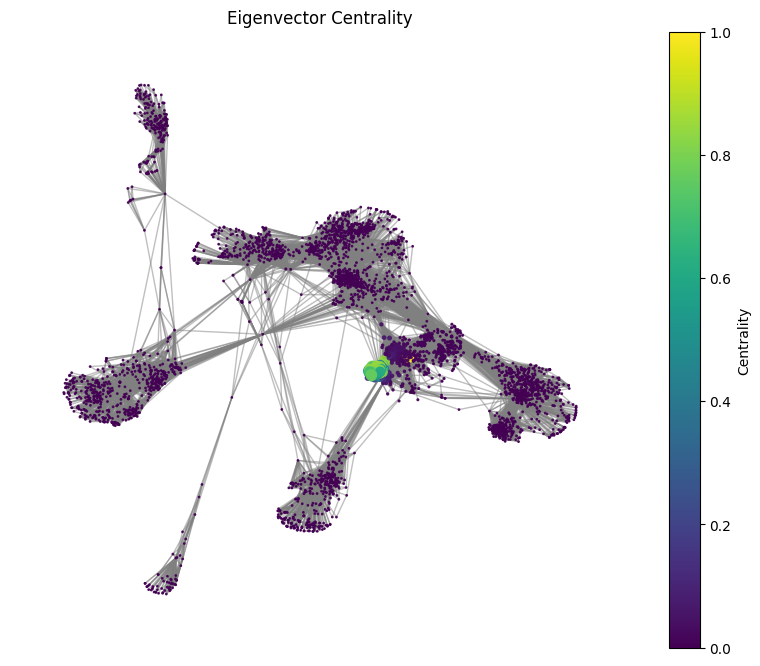

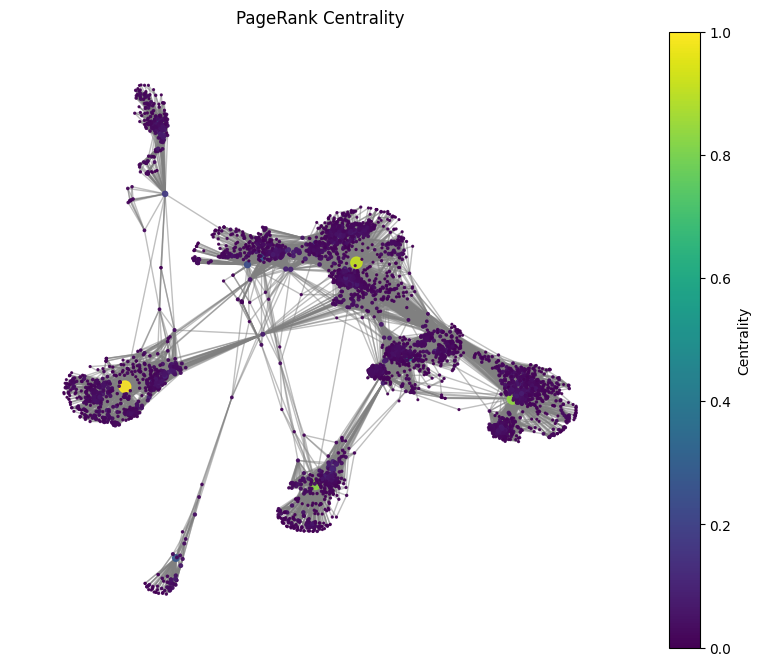

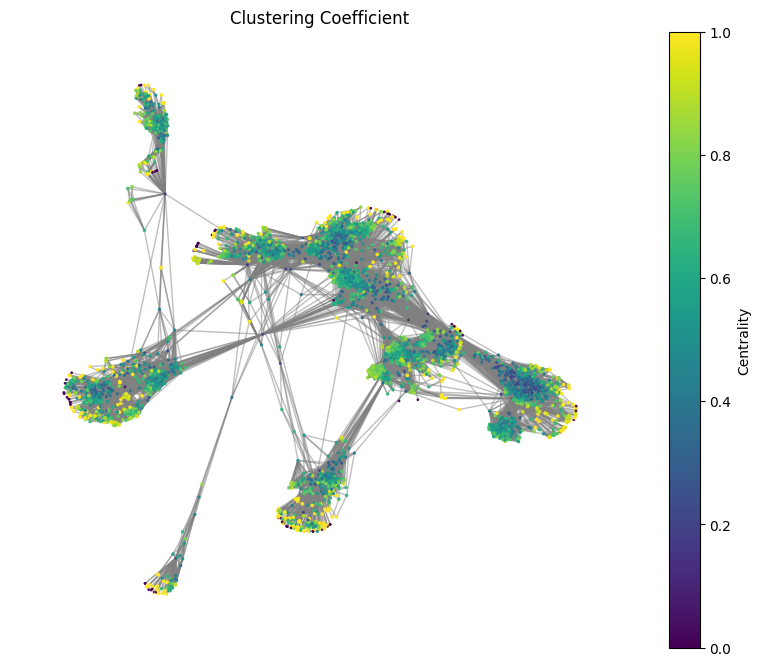

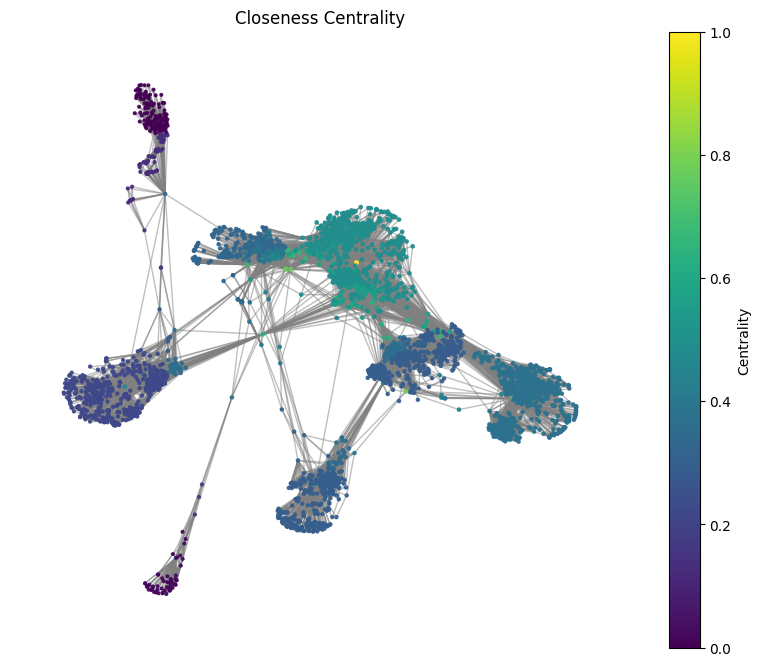

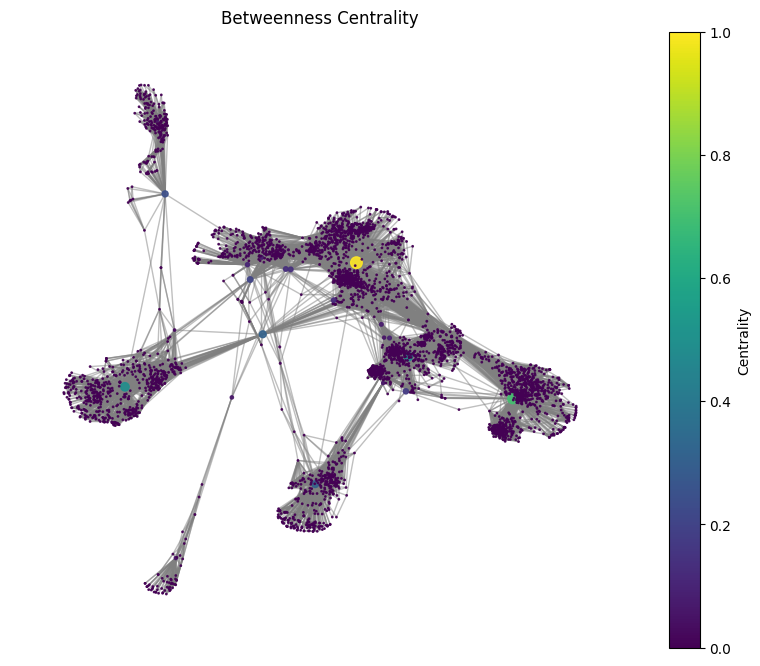

In [ ]:
centralities_facebook = centrality_analysis(facebook, pos_facebook)

<ipython-input-32-551b80c6e83f>:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Centrality')


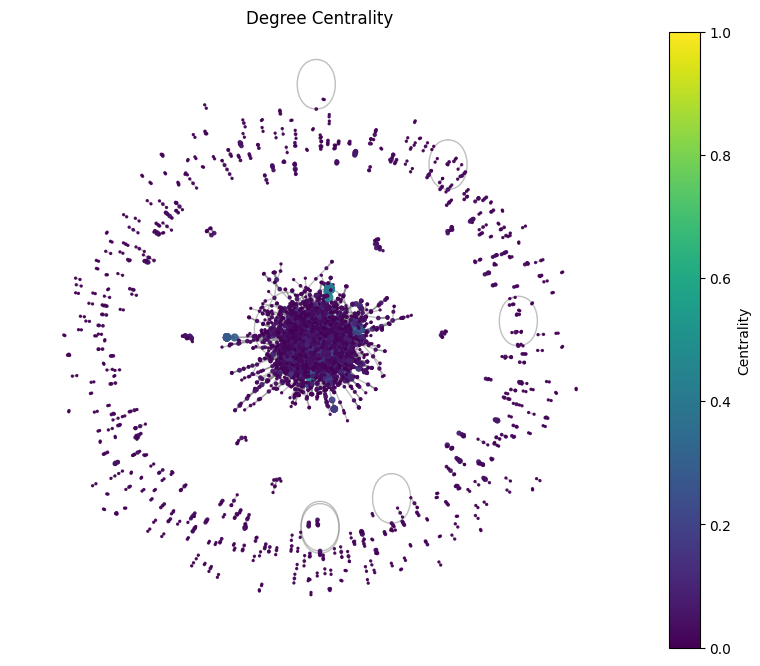

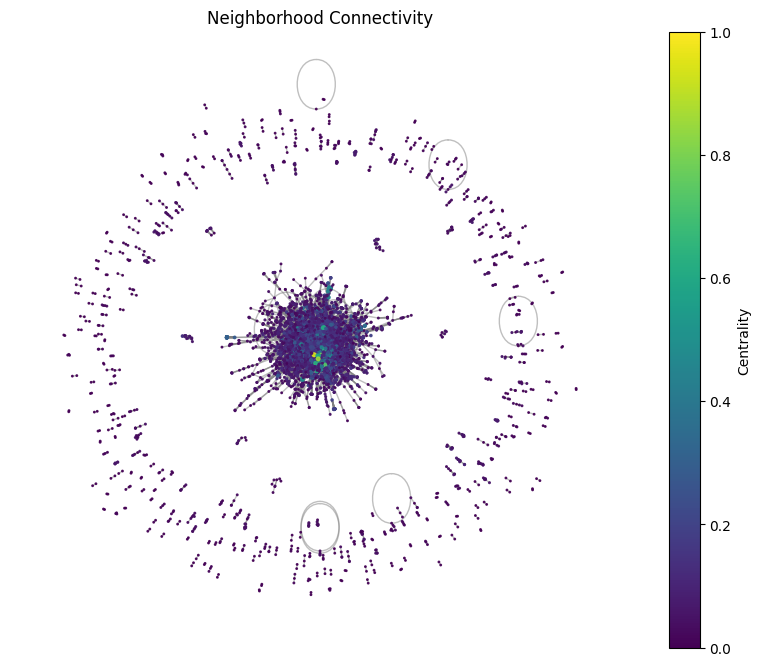

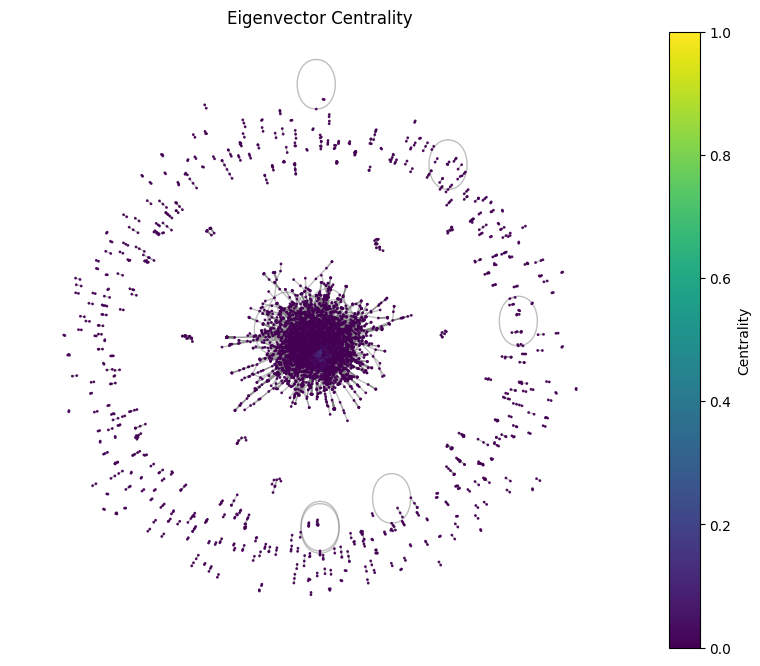

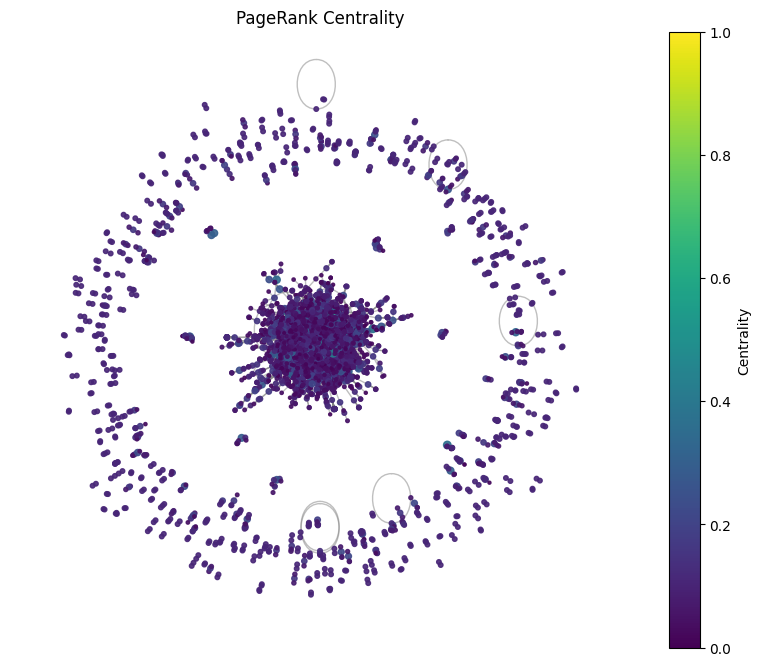

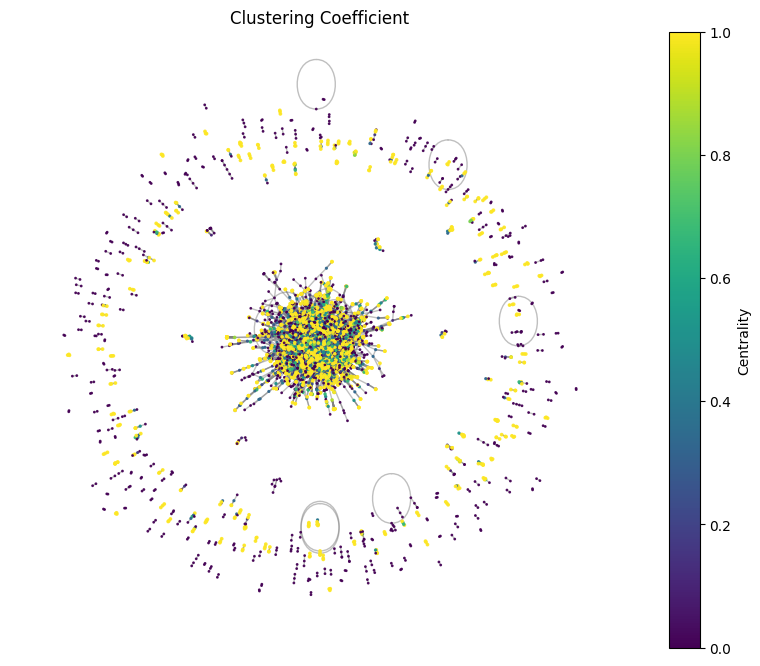

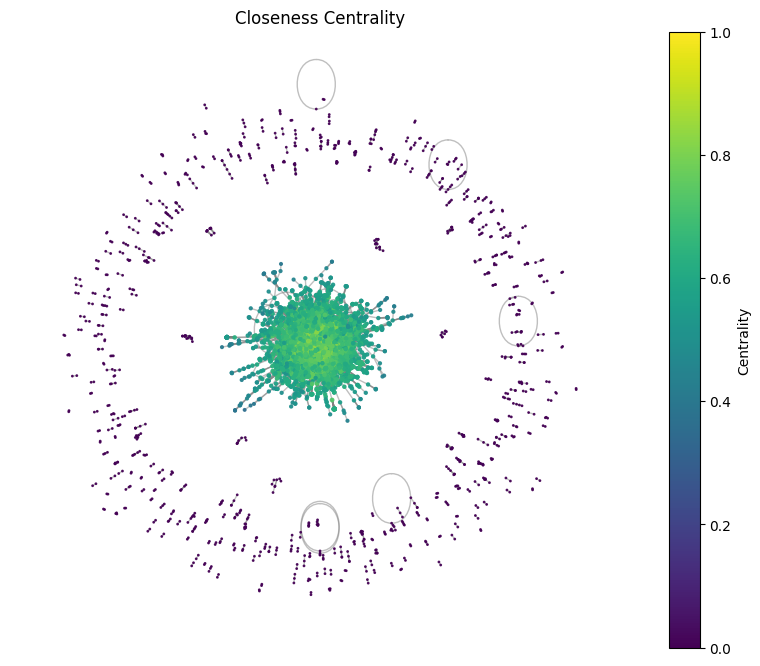

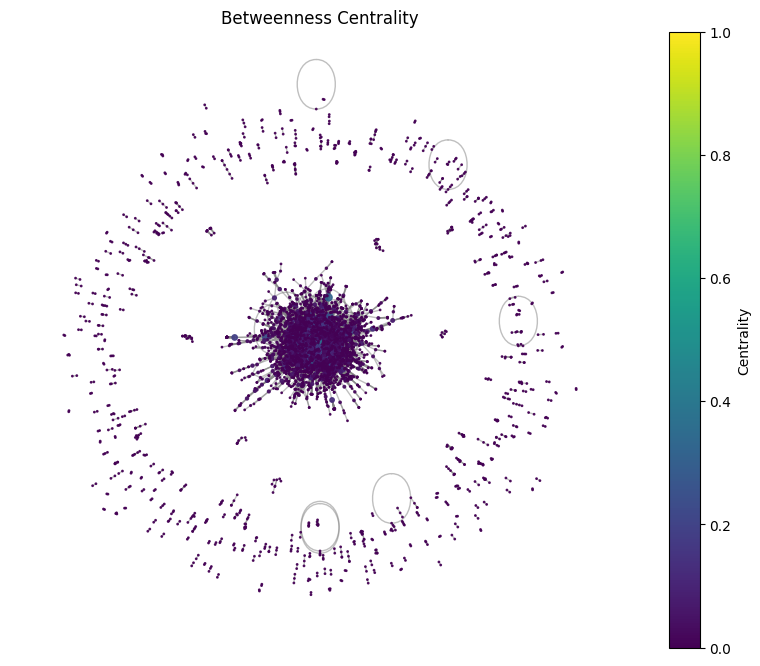

In [ ]:
centrality_analysis(grqc, pos_grqc)

<ipython-input-32-551b80c6e83f>:43: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Centrality')


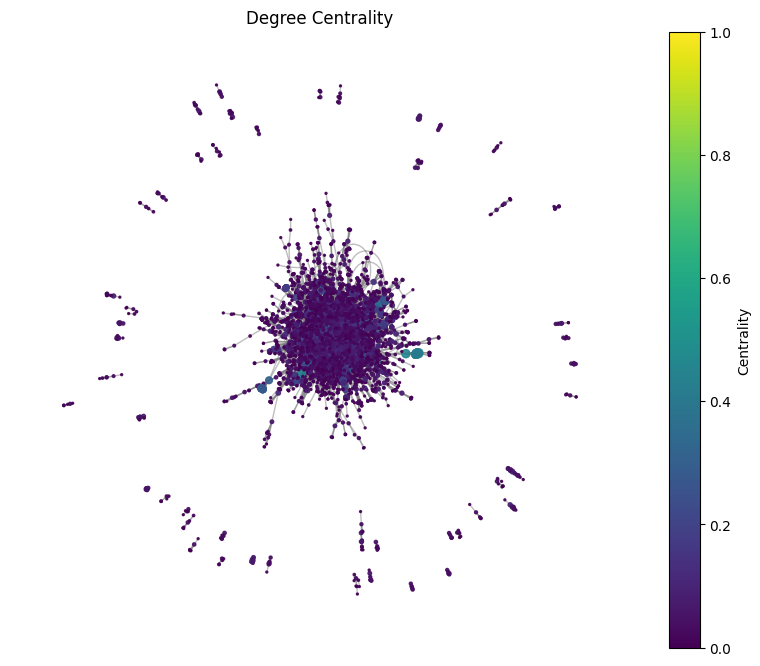

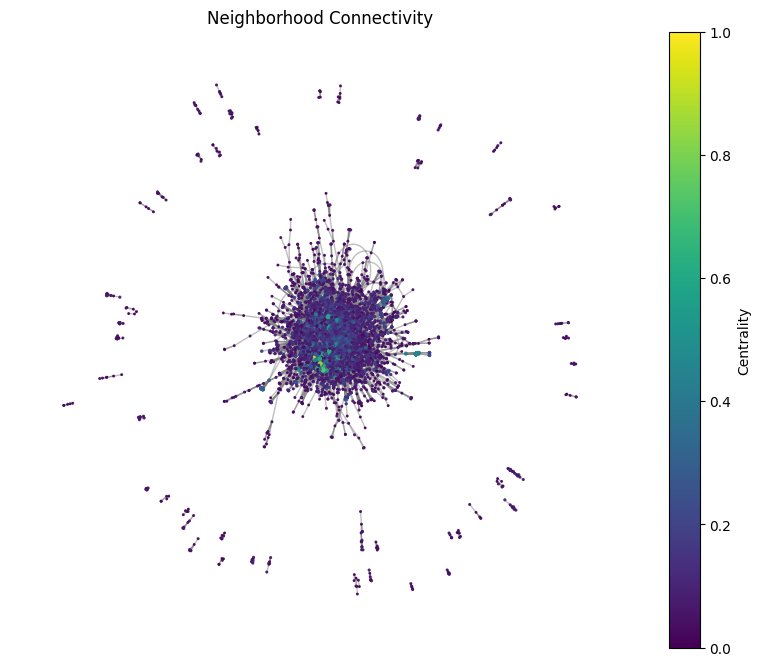

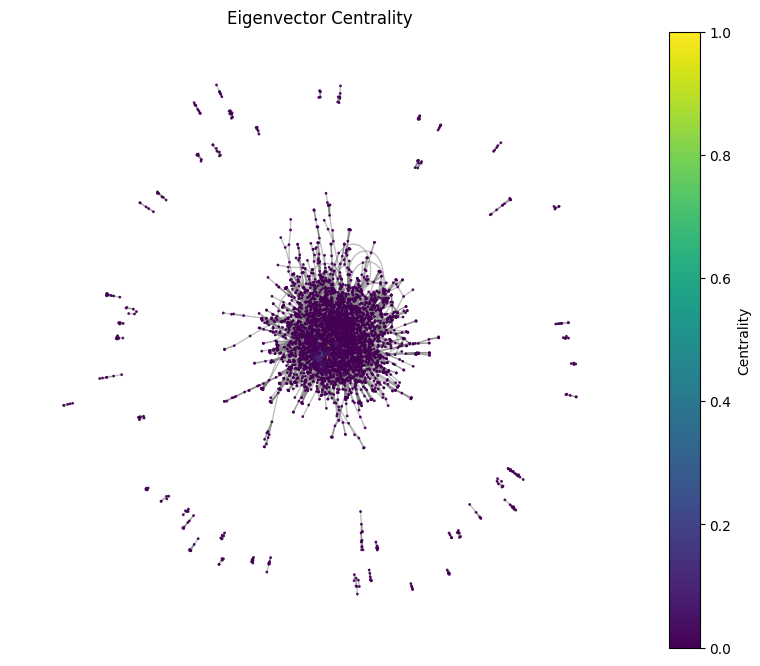

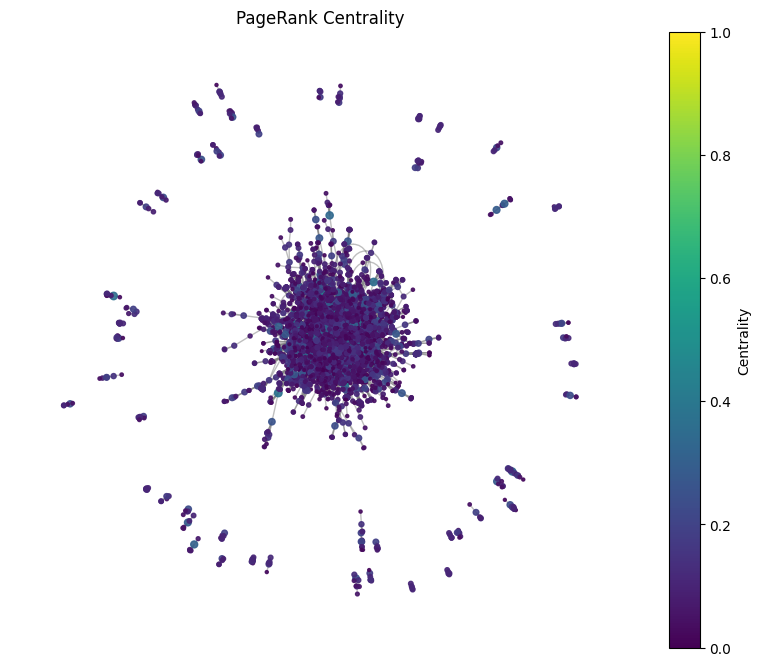

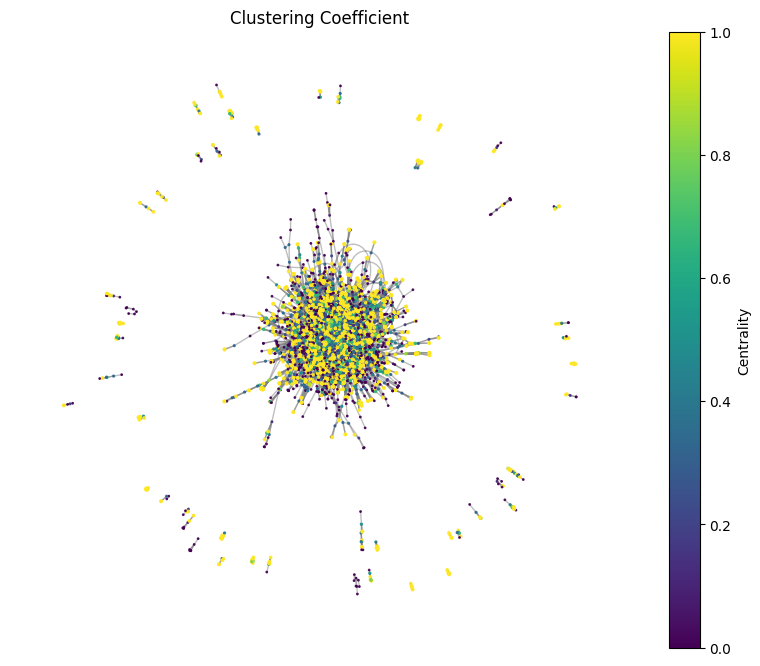

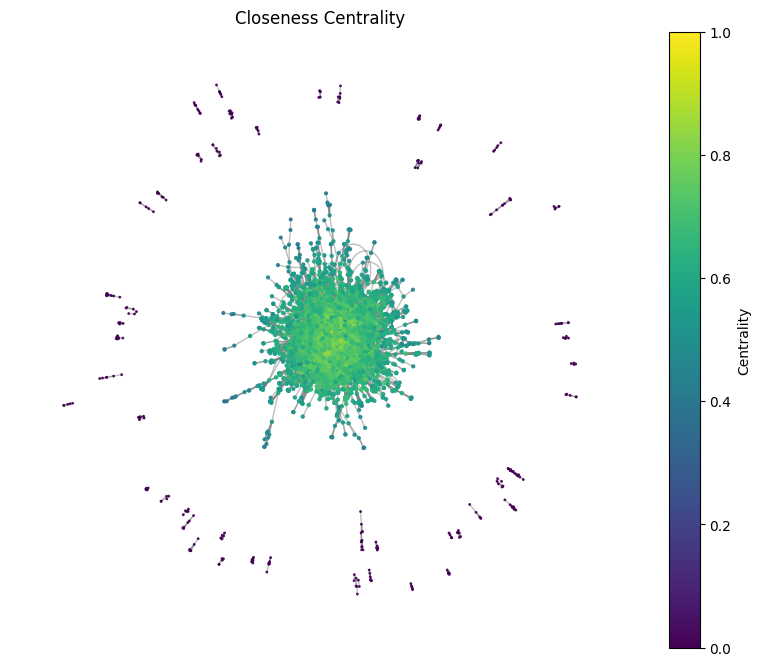

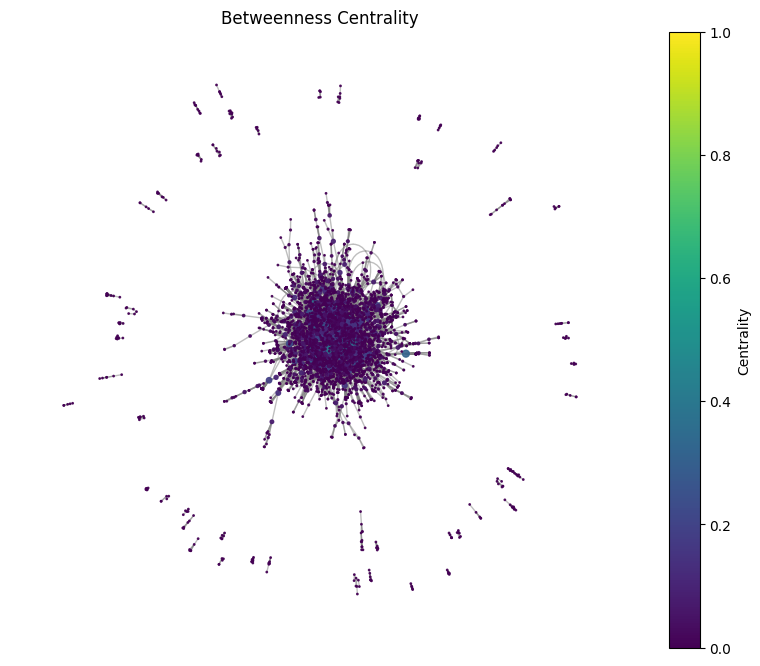

In [ ]:
centrality_analysis(grqc_cleaned, pos_grqc_cleaned)

In [ ]:
nb_nodes = facebook.number_of_nodes()
nb_top_10percent_nodes = int(0.1*nb_nodes) # we take the top 10% of the nodes

nodes_top10 = set(list(dict(sorted(centralities_facebook["degree_centrality"].items(), key=lambda item: item[1], reverse=True)).keys())[:nb_top_10percent_nodes])
nodes_top10 &= set(list(dict(sorted(centralities_facebook["pagerank_centrality"].items(), key=lambda item: item[1], reverse=True)).keys())[:nb_top_10percent_nodes])
nodes_top10 &= set(list(dict(sorted(centralities_facebook["closeness_centrality"].items(), key=lambda item: item[1], reverse=True)).keys())[:nb_top_10percent_nodes])
nodes_top10 &= set(list(dict(sorted(centralities_facebook["betweenness_centrality"].items(), key=lambda item: item[1], reverse=True)).keys())[:nb_top_10percent_nodes])

#print(len(nodes_top10))

for node in nodes_top10:
    print(node)
    print(centralities_facebook["degree_centrality"][node])
    print(centralities_facebook["pagerank_centrality"][node])
    print(centralities_facebook["closeness_centrality"][node])
    print(centralities_facebook["betweenness_centrality"][node])

0
0.08593363051015354
0.006289602618466542
0.35334266713335666
0.14630592147442917
1800
0.06067360079247152
0.0006984646532952213
0.32159923542529467
0.00015282194124476646
1420
0.03665180782565626
0.0004405224865045448
0.33870156014091596
0.006056580020060359
1684
0.1961367013372957
0.006367162138306824
0.39360561458231796
0.3377974497301992
1813
0.03863298662704309
0.00048062132421869874
0.3199176041831722
0.00010104677450332539
916
0.03640416047548291
0.00042155073063063117
0.33669640623697156
0.0007164342020876627
917
0.032194155522535906
0.0007331559412352087
0.3202982470056318
0.0003063325697344238
1431
0.05448241703813769
0.0006584499181463515
0.3204253293128075
0.00015418331946305362
925
0.041357107478949974
0.0004844567692360999
0.3372588323728389
0.0007564082942056397
414
0.03937592867756315
0.001800299047070226
0.3695433330282786
0.04763337297172344
1577
0.04210004952947003
0.0005301520358229054
0.35718708536045995
0.03978470502937034
1835
0.04507181773155027
0.0005452217677

In [ ]:
dict(sorted(centralities_facebook["degree_centrality"].items(), key=lambda item: item[1], reverse=True))

{107: 0.258791480931154,
 1684: 0.1961367013372957,
 1912: 0.18697374938088163,
 3437: 0.13546310054482416,
 0: 0.08593363051015354,
 2543: 0.07280832095096582,
 2347: 0.07206537890044576,
 1888: 0.0629024269440317,
 1800: 0.06067360079247152,
 1663: 0.058197127290737984,
 1352: 0.05794947994056463,
 2266: 0.05794947994056463,
 483: 0.057206537890044575,
 348: 0.05671124318969787,
 1730: 0.055968301139177806,
 1985: 0.0554730064388311,
 1941: 0.05522535908865775,
 2233: 0.0549777117384844,
 2142: 0.054730064388311045,
 1431: 0.05448241703813769,
 1199: 0.05373947498761763,
 1584: 0.05225359088657751,
 2206: 0.052005943536404156,
 1768: 0.051758296186230804,
 2229: 0.0512630014858841,
 2410: 0.0512630014858841,
 2611: 0.0512630014858841,
 1086: 0.050767706785537395,
 1589: 0.050767706785537395,
 2047: 0.050767706785537395,
 2218: 0.050767706785537395,
 2078: 0.05052005943536404,
 1993: 0.05027241208519068,
 2123: 0.05027241208519068,
 1746: 0.05002476473501733,
 2464: 0.0500247647350173

# Community Detection

## k-Core Decomposition

 This algorithm identifies clusters based on the core level, where a k-core of a graph is a maximal connected subgraph in which all vertices have degree at least k. It's useful for understanding the graph's structure and identifying influential communities. Here, we Used it to simplify the graph analysis by peeling off layers of less connected nodes.

In [ ]:
def k_core_algorithm(G, pos: dict = None, layout_seed : int = layout_seed):
    k_core = nx.k_core(G, k=5)

    if pos == None:
        pos = nx.spring_layout(G, seed=layout_seed)

    plt.figure(figsize=(8, 6))
    nx.draw(k_core, pos, with_labels=False, node_color='skyblue', edge_color='k', node_size=15)
    plt.title("k-Core Decomposition")
    plt.show()

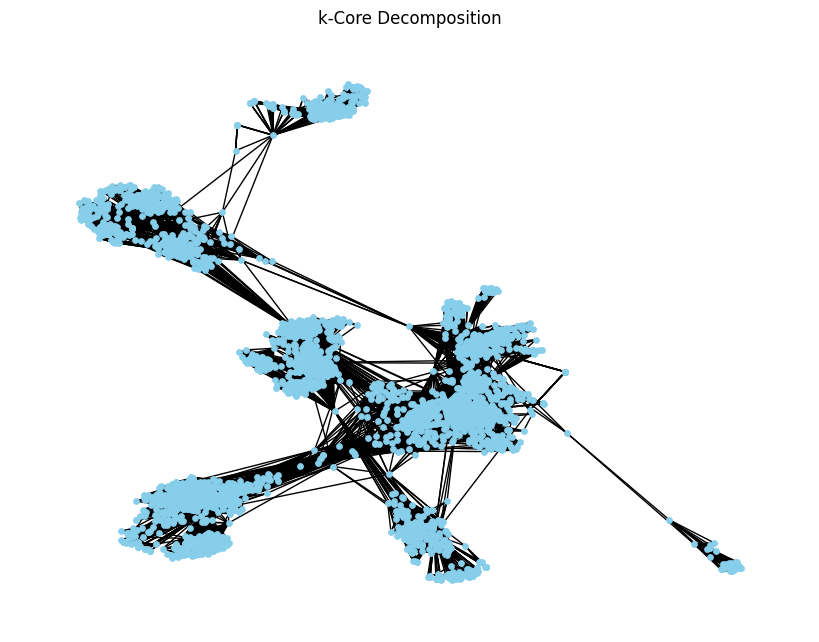

In [ ]:
k_core_algorithm(facebook)

In [ ]:
k_core_algorithm(grcq.remove_edges_from(nx.selfloop_edges(grcq)))

AttributeError: 'NoneType' object has no attribute 'is_multigraph'

## Louvain Algorithm

This method aims to detect communities by maximizing modularity through a heuristic approach. It's an iterative process that aggregates nodes into communities at various scales. Here, we used due to its hierarchical clustering approach.

In [ ]:
def louvain_algorithm(G, pos: dict = None, layout_seed : int = layout_seed):
    # Compute the best partition
    partition = community_louvain.best_partition(G)

    if pos == None:
        pos = nx.spring_layout(G, seed=layout_seed)

    # Prepare the figure
    plt.figure(figsize=(8, 6))

    # Define your 15 named colors
    colors = [
        'red', 'blue', 'green', 'yellow', 'orange',
        'purple', 'cyan', 'magenta', 'lime', 'pink',
        'teal', 'lavender', 'olive', 'brown', 'navy'
    ]

    communities = dict()

    # Ensure we loop over communities and colors correctly
    for i, comm in enumerate(set(partition.values())):
        # List of nodes in the current community
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == comm]
        communities[comm] = list_nodes

        # Draw nodes with the community-specific color
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size=15, node_color=colors[i % len(colors)])

    # Draw the edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Set the title and show the plot
    plt.title("Community Detection: Louvain Algorithm")
    plt.axis('off')  # Optional: Hide the axes
    plt.show()

    return communities

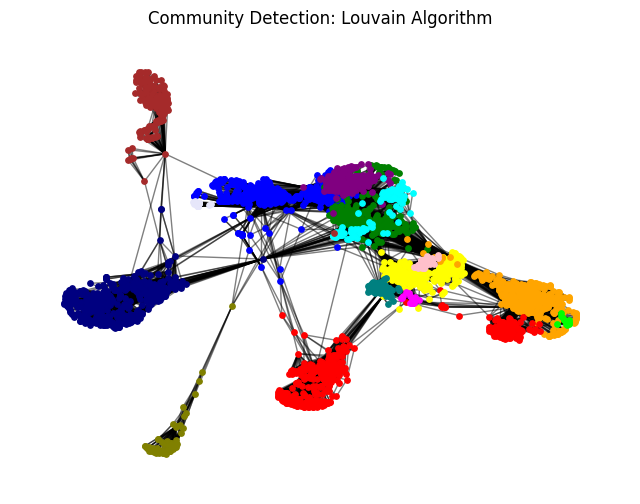

CPU times: user 3.54 s, sys: 147 ms, total: 3.69 s
Wall time: 3.58 s


In [ ]:
%time communities_facebook = louvain_algorithm(facebook, pos_facebook)

In [ ]:
communities

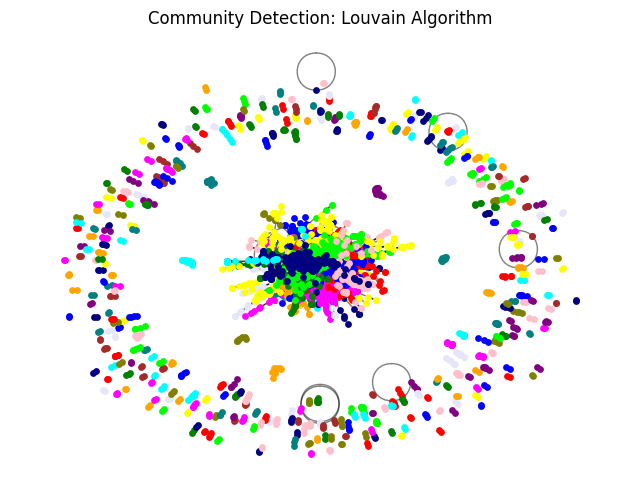

CPU times: user 7.39 s, sys: 276 ms, total: 7.66 s
Wall time: 8.62 s


In [ ]:
%time louvain_algorithm(grqc, pos_grqc)

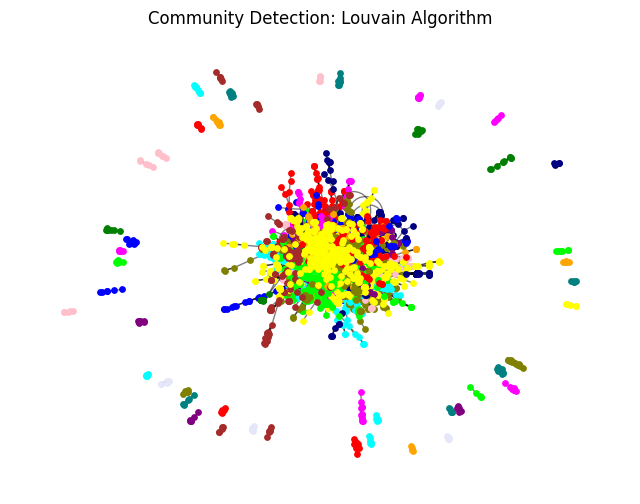

CPU times: user 3.06 s, sys: 155 ms, total: 3.22 s
Wall time: 6.33 s


In [ ]:
%time louvain_algorithm(grqc_cleaned, pos_grqc_cleaned)

## Girvan-Newman (too long to compute)

In [ ]:
def girvan_newman_algorithm(G, pos: dict = None, layout_seed : int = layout_seed):
    # Apply the Girvan-Newman algorithm
    communities_generator = girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)

    # Convert to list of sets
    communities = sorted(map(sorted, next_level_communities))

    if pos == None:
        pos = nx.spring_layout(G, seed=layout_seed)

    plt.figure(figsize=(8, 6))

    # Define colors for each community
    colors = ['red', 'blue', 'green', 'yellow', 'orange']
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_size=15, node_color=colors[i % len(colors)])
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title("Community Detection: Girvan-Newman Approach")
    plt.axis('off')
    plt.show()

In [ ]:
%time girvan_newman_algorithm(facebook)

In [ ]:
%time girvan_newman_algorithm(grqc)

In [ ]:
%time girvan_newman_algorithm(grqc_cleaned)